In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pipeline.utils import read_json, make_folder

# EXP 4: Compare SingleCC with KAM-CAL and CAPUCHIN

## Read results from disc

In [3]:
datasets = ['adult', 'german', 'compas', 'cardio', 'bank', 'meps16', 'lawgpa', 'credit', 'UFRGS']
y_cols = ['Income Binary', 'credit', 'two_year_recid'] + ['Y' for i in range(6)]
sensi_cols = ['sex', 'age', 'race'] + ['C0' for i in range(6)]

seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 0xdeadcafe, 0xdeadbeef, 0xbeefcafe]

In [4]:
# extracting results from SingleCC and no intervention
exp_setting = 'Single_eval'
exp_suffix = 'XGBall'

res_path = 'intermediate/models/'
group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff']
settings = ['D', 'E', 'F']

eval_path = 'intermediate/evals/'

eval_file = exp_setting+'_'+exp_suffix+'_data'+str(len(datasets))+'_n'+str(len(seeds))+'.csv'


all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
    single_df = pd.DataFrame(columns=['data', 'seed', 'setting', 'group', 'metric', 'value'])

    for data_name in datasets:
        for seed in seeds:
            eval_res = read_json(res_path+data_name+'/'+'-'.join([exp_setting, str(seed), exp_suffix]))
            for setting in settings:
                for group in ['all', 'G0', 'G1']:
                    base = [data_name, seed, setting, group]
                    for metric_i in group_eval_metrics:
                        single_df.loc[single_df.shape[0]] = base + [metric_i, eval_res[setting][group][metric_i]]
                for metric_i in overall_metrics:
                    single_df.loc[single_df.shape[0]] = [data_name, seed, setting, 'all'] + [metric_i, eval_res[setting]['all'][metric_i]]

    single_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    single_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))
    

Save evaluation results at intermediate/evals/Single_eval_XGBall_data9_n20.csv


In [5]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if x.iloc[0] in ['EQDiff', 'AvgOddsDiff', 'SPDiff']: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if x.iloc[0] in ['EQDiff', 'AvgOddsDiff', 'SPDiff']: # difference change to 1-abs(x)
        if x.iloc[1] < 0: 
            return 0
        else: # G0 has better outcome
            return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [6]:
single_df['norm_value'] = single_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
single_df['norm_flag'] = single_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

single_df['setting'] = single_df['setting'].replace({'D':'CAPUCHIN', 'E':'KAM-CAL', 'F':'SingleCC'})
single_df.head()

,data,seed,setting,group,metric,value,norm_value,norm_flag
0,adult,1,CAPUCHIN,all,AUC,0.657000,0.657000,0
1,adult,1,CAPUCHIN,all,ACC,0.758000,0.758000,0
2,adult,1,CAPUCHIN,all,SR,0.221782,0.221782,0
3,adult,1,CAPUCHIN,all,BalAcc,0.656662,0.656662,0
4,adult,1,CAPUCHIN,G0,AUC,0.647000,0.647000,0


In [7]:
single_df.query('setting == "KAM-CAL" and data =="adult" and seed == 1 and group == "all" and metric == "DI"')

,data,seed,setting,group,metric,value,norm_value,norm_flag
30,adult,1,KAM-CAL,all,DI,0.793989,0.793989,0


In [8]:
single_df.query('setting == "SingleCC" and data =="adult" and seed == 1 and group == "all" and metric == "DI"')

,data,seed,setting,group,metric,value,norm_value,norm_flag
47,adult,1,SingleCC,all,DI,0.754834,0.754834,0


## Draw barplot

In [9]:
def bar_plots(df, vis_name, vis_datasets, vis_metric, vis_settings, 
              legend_names=None, font_label=26, font_legend=18, 
              colors=['#45b1e8', '#4166f5' ,'#20603d'], bg_color = '#f3f3f3', 
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=4, save_to_disc=True, 
              plot_path = 'intermediate/evals/plots/'):
    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    bar_mean = []
    bar_std = []
    dash_filling = []
    x_bars = []
    ind = 0
    for off_i, name in enumerate(vis_datasets):
        vis_df = input_df[(input_df['data']==name) & (input_df['metric']==vis_metric) & (input_df['group']=='all')]
        for setting_i in vis_settings:
            set_df = vis_df[vis_df['setting']==setting_i]
            y_values = np.array(set_df['norm_value'])
            n_reverse = sum(np.array(set_df['norm_flag']))
            if n_reverse > int(len(y_values) * 0.7): # majoirty of cases in which G0 has better outcomes
                dash_filling.append(True)
            else:
                dash_filling.append(False)
            bar_mean.append(np.mean(y_values))
            bar_std.append(np.std(y_values))
            x_bars.append(ind+off_i*2)
                
            ind += 0.83
    bplot = ax.bar(x_bars, bar_mean, yerr=bar_std)

    n_bars = len(vis_settings)
    for idx, patch in enumerate(bplot):
        patch.set_facecolor(colors[idx % n_bars])
        
        if dash_filling[idx]:
            patch.set_hatch('//')
            patch.set_edgecolor("#cb4154")
        else:
            patch.set_edgecolor("black")
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    # add labels for settings 
    for idx, setting_i, color_i, legend_i in zip(range(len(vis_settings)), vis_settings, colors, legends):
        ax.bar(-2, 1, ec='black', fc=color_i, label=legend_i)

    ax.set_facecolor(bg_color)

    plt.xlim([-1, max(x_bars)+1])
    plt.xticks([(x-1)*4.5+0.5 for x in range(1, len(datasets)+1)])
    if x_ticks:
        locs, labels=plt.xticks();
        plt.xticks(locs, x_ticks, horizontalalignment='center', fontsize=font_label-10, rotation=0);

    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(plot_path+vis_name+'_'+vis_metric+'.pdf', bbox_inches="tight")
    print('Bar plot is saved at ', plot_path+vis_name+'_'+vis_metric+'.pdf')

Bar plot is saved at  intermediate/evals/plots/exp4/exp4_BalAcc.pdf


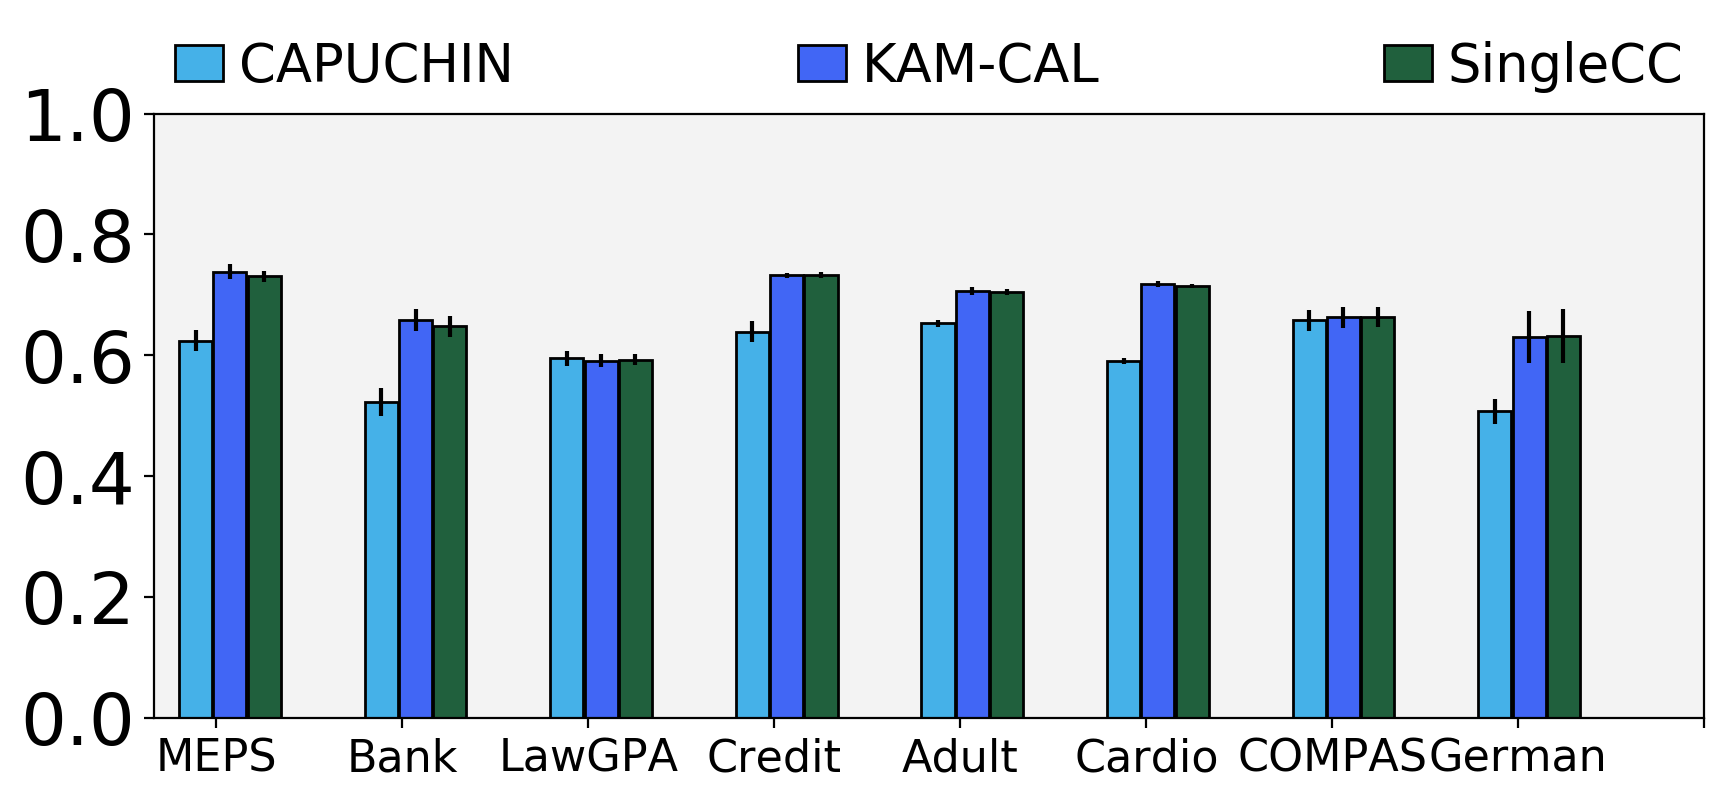

In [10]:
plot_path = 'intermediate/evals/plots/'
exp_name = 'exp4'
# initiate a new folder for the plots
exp_path = plot_path+exp_name+'/'
make_folder(exp_path)



exp_settings = ['CAPUCHIN', 'KAM-CAL', 'SingleCC']

exp_datasets = ['meps16', 'bank', 'lawgpa',  'credit', 'adult', 'cardio', 'compas', 'german']
exp_ticks = ['MEPS', 'Bank', 'LawGPA', 'Credit', 'Adult',  'Cardio', 'COMPAS', 'German']

exp_metric = 'BalAcc'
bar_plots(single_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


Bar plot is saved at  intermediate/evals/plots/exp4/exp4_DI.pdf


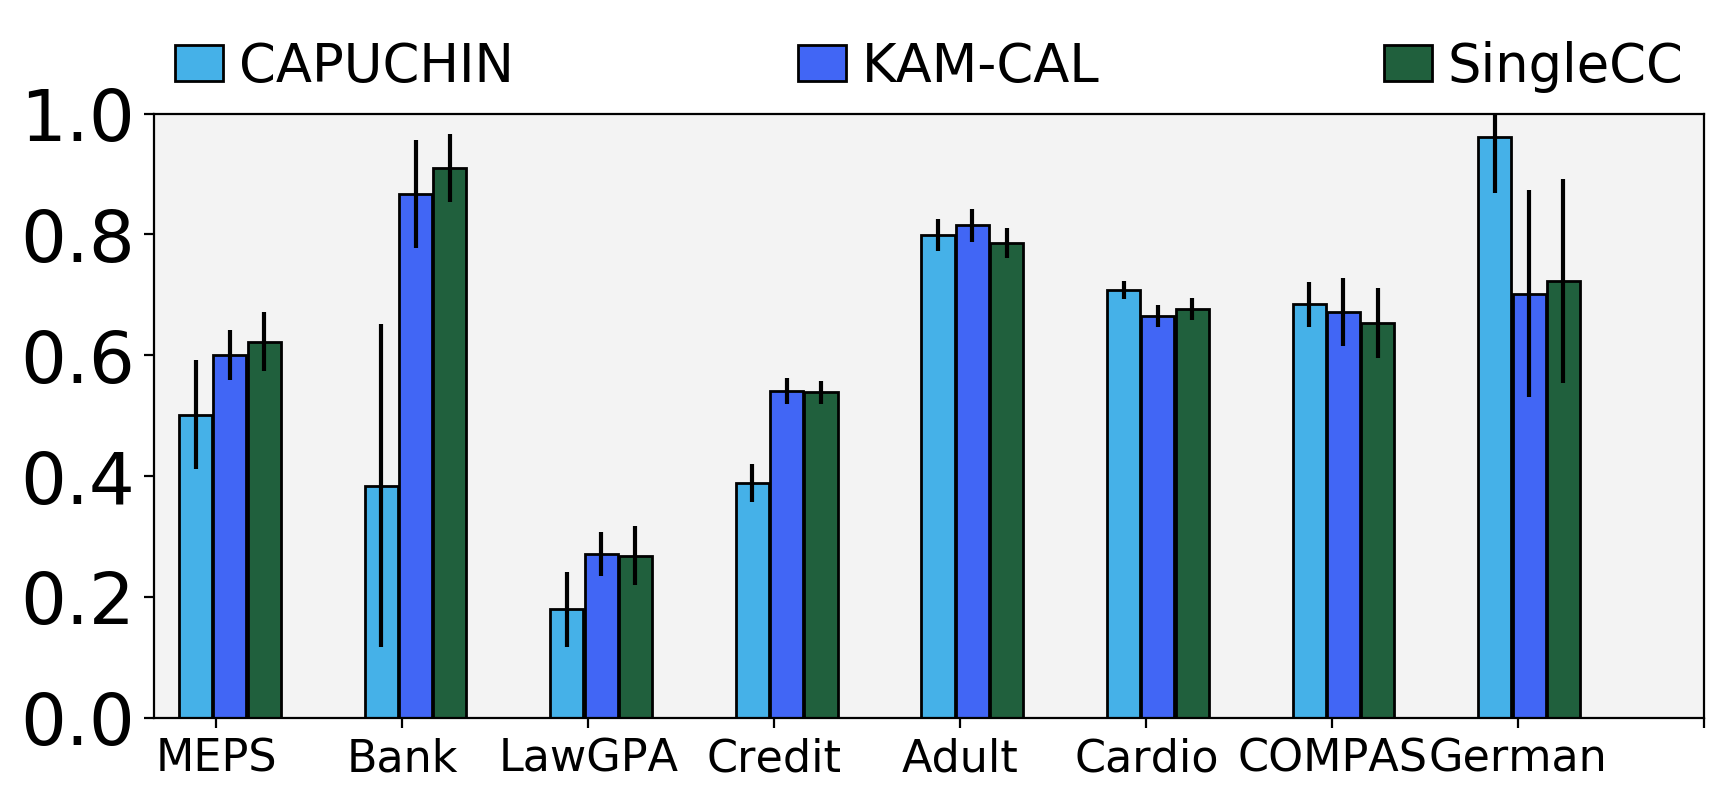

In [11]:
exp_metric = 'DI'
bar_plots(single_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


Bar plot is saved at  intermediate/evals/plots/exp4/exp4_SPDiff.pdf


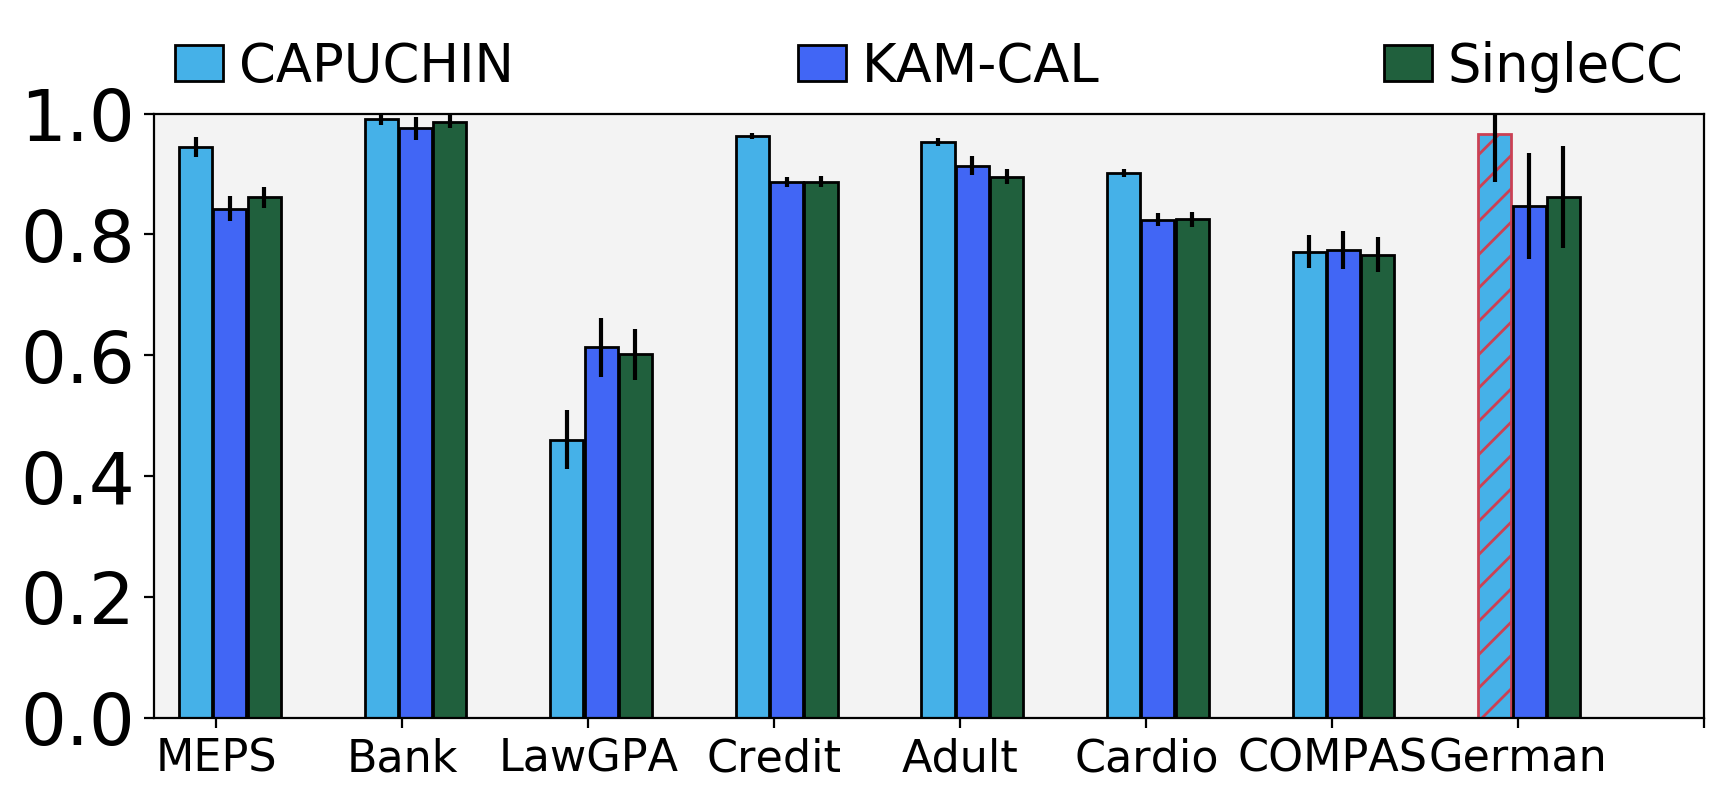

In [12]:
exp_metric = 'SPDiff'
bar_plots(single_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


Bar plot is saved at  intermediate/evals/plots/exp4/exp4_AvgOddsDiff.pdf


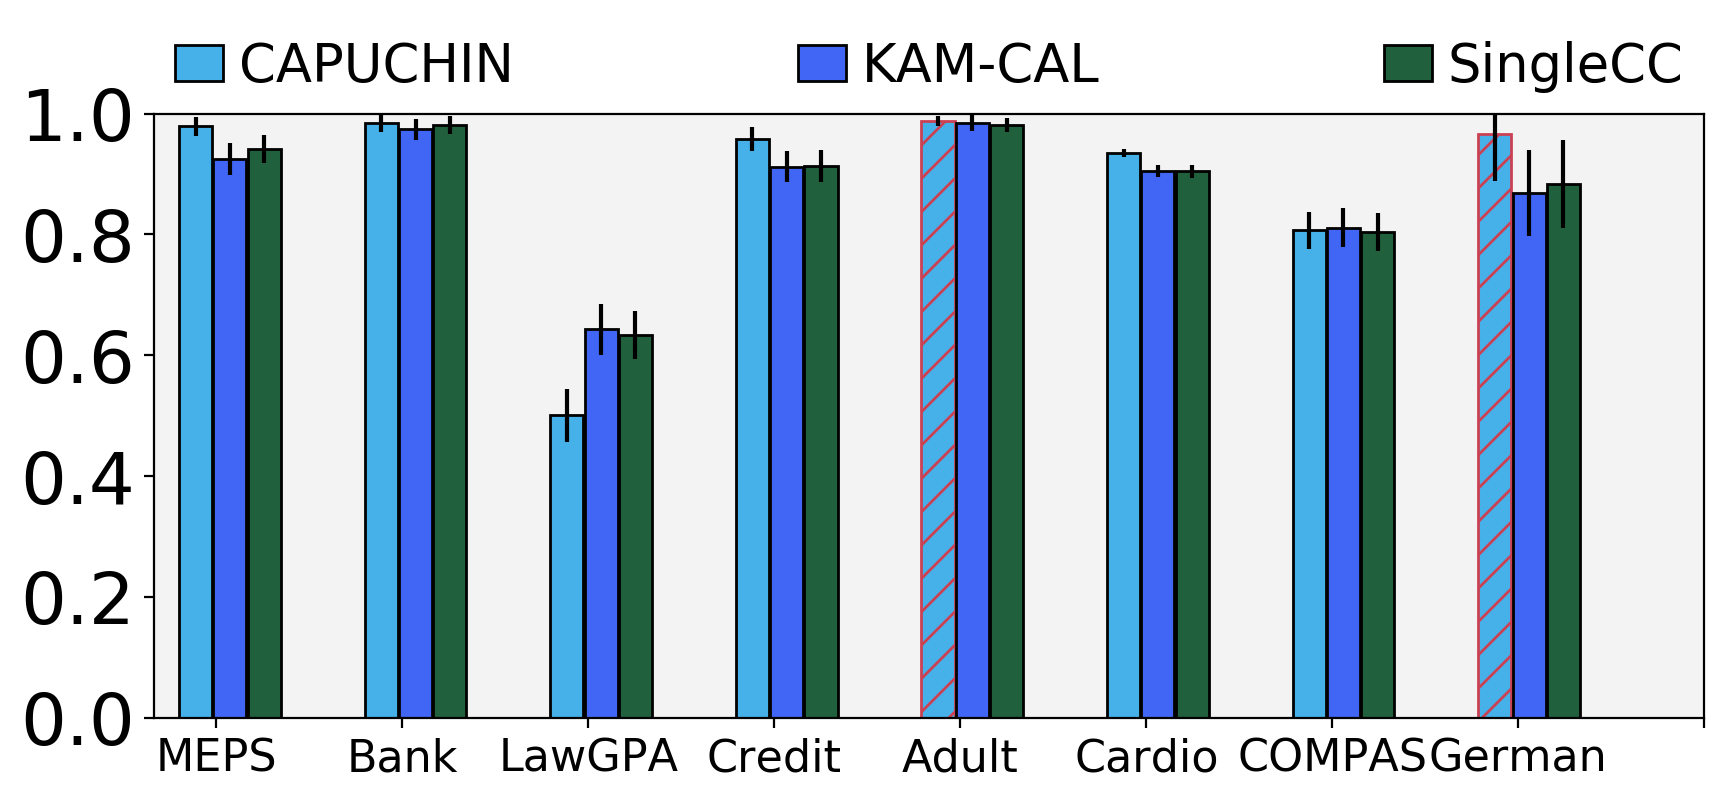

In [13]:
exp_metric = 'AvgOddsDiff'
bar_plots(single_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)
